# Thử nghiệm và Cải tiến cho Co-Training

**Mục tiêu:**
Notebook này thực hiện quá trình sweep (thử nghiệm) các tham số và chiến lược tách view khác nhau cho thuật toán Co-Training nhằm tìm ra cấu hình tối ưu và cải thiện hiệu năng so với kết quả ban đầu.

**Các bước thực hiện:**
1.  Định nghĩa các bộ tham số và chiến lược tách view để thử nghiệm:
    *   `TAU` (Ngưỡng tự tin): `[0.9, 0.8]`
    *   `MAX_NEW_PER_ITER` (Số mẫu mới tối đa mỗi vòng): `[250, 500]`
    *   **View Splitting Strategies**:
        *   `default`: Tách tự động (sensor/lag vs. context/time).
        *   `manual`: Tách thủ công các feature thời tiết sang View 2.
2.  Sử dụng `papermill` để chạy notebook `05_semi_co_training.ipynb` với 8 cấu hình khác nhau.
3.  Tự động lưu kết quả vào thư mục `data/processed/` với tiền tố `11_ID_*`.
4.  Tổng hợp và trực quan hóa kết quả để so sánh hiệu năng và chọn ra mô hình tốt nhất.

In [1]:
from pathlib import Path
import papermill as pm
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# -------- Cấu hình thử nghiệm --------
PROJECT_ROOT = Path(".").resolve().parent
print(f"Project Root: {PROJECT_ROOT}")

KERNEL = "KhaiPhaDuLieu"

# --- Tham số để sweep ---
TAU_LIST = [0.9, 0.8]
MAX_NEW_PER_ITER_LIST = [100, 250, 500] # Thêm điểm để vẽ biểu đồ đường

# --- Chiến lược tách view ---
# Đọc danh sách features từ file đã tạo ở notebook 03
feature_list_path = PROJECT_ROOT / "data" / "processed" / "03_feature_list.csv"
df_features = pd.read_csv(feature_list_path)
all_features = df_features["feature"].tolist()

# 1. Manual split: View 2 chứa các đặc trưng thời tiết, View 1 chứa phần còn lại
manual_view2_cols = [col for col in all_features if any(sub in col for sub in ["wd", "temp", "pres", "humi"])]
manual_view1_cols = [col for col in all_features if col not in manual_view2_cols]

# 2. PCA-based split: Tách dựa trên principal components
print("Tính toán PCA-based split...")
semi_dataset_path = PROJECT_ROOT / "data" / "processed" / "02_dataset_for_semi.parquet"
df_semi = pd.read_parquet(semi_dataset_path)

# Chỉ sử dụng labeled data để tính PCA
df_labeled = df_semi[df_semi["is_labeled"] == True].copy()

# Lọc chỉ các features numeric (loại bỏ categorical như 'wd', 'station')
numeric_features = [col for col in all_features if col not in ['wd', 'station']]
X_labeled = df_labeled[numeric_features].fillna(0)  # Fill NaN nếu có

# Chuẩn hóa và tính PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_labeled)

# Tính PCA với số components bằng số features
n_components = min(20, len(numeric_features))  # Giới hạn số PC để tăng tốc
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

# Lấy absolute loadings và phân chia features
# View 1: Features có loading cao ở các PC chẵn (PC0, PC2, PC4,...)
# View 2: Features có loading cao ở các PC lẻ (PC1, PC3, PC5,...)
loadings = np.abs(pca.components_)  # Shape: (n_components, n_features)

even_pcs = loadings[0::2, :]  # PC0, PC2, PC4,...
odd_pcs = loadings[1::2, :]   # PC1, PC3, PC5,...

# Tính tổng loading cho mỗi feature
even_loadings = even_pcs.sum(axis=0)
odd_loadings = odd_pcs.sum(axis=0)

# Phân chia features dựa trên loading cao hơn
pca_view1_cols = [numeric_features[i] for i in range(len(numeric_features)) if even_loadings[i] >= odd_loadings[i]]
pca_view2_cols = [numeric_features[i] for i in range(len(numeric_features)) if even_loadings[i] < odd_loadings[i]]

# Thêm categorical features vào view1 (nếu có)
categorical_features = [col for col in all_features if col in ['wd', 'station']]
if categorical_features:
    pca_view1_cols.extend(categorical_features)

print(f"PCA split: View1={len(pca_view1_cols)} features, View2={len(pca_view2_cols)} features")

VIEW_STRATEGIES = {
    "default": {
        "VIEW1_COLS": None,  # Để notebook 05 tự tách
        "VIEW2_COLS": None,
    },
    "manual_weather_split": {
        "VIEW1_COLS": manual_view1_cols,
        "VIEW2_COLS": manual_view2_cols,
    },
    "pca_based_split": {
        "VIEW1_COLS": pca_view1_cols,
        "VIEW2_COLS": pca_view2_cols,
    }
}

Project Root: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard
Tính toán PCA-based split...
PCA split: View1=33 features, View2=18 features


In [2]:
# -------- Chạy thử nghiệm với Papermill --------
# Tạo thư mục runs nếu chưa có
runs_dir = Path("runs")
runs_dir.mkdir(exist_ok=True)

experiment_id = 1
config_list = []

# Tạo danh sách tất cả các cấu hình
for view_name, view_cols in VIEW_STRATEGIES.items():
    for tau in TAU_LIST:
        for max_new in MAX_NEW_PER_ITER_LIST:
            config_list.append({
                "view_name": view_name,
                "tau": tau,
                "max_new_per_iter": max_new,
                "view1_cols": view_cols["VIEW1_COLS"],
                "view2_cols": view_cols["VIEW2_COLS"],
            })

# Chạy lặp qua các cấu hình
total_experiments = len(config_list)
for config in config_list:
    print(f"--- Thử nghiệm {experiment_id}/{total_experiments}: "
          f"View='{config['view_name']}', TAU={config['tau']}, MAX_NEW={config['max_new_per_iter']} ---")

    metrics_path = f"data/processed/11_{experiment_id:02d}_metrics_co_training.json"
    output_notebook_path = f"runs/11_{experiment_id:02d}_co_training_run.ipynb"

    try:
        pm.execute_notebook(
            input_path="05_semi_co_training.ipynb",
            output_path=output_notebook_path,
            parameters=dict(
                SEMI_DATASET_PATH="data/processed/02_dataset_for_semi.parquet",
                CUTOFF="2017-01-01",
                TAU=config["tau"],
                MAX_ITER=2, # Giữ nguyên MAX_ITER
                MAX_NEW_PER_ITER=config["max_new_per_iter"],
                MIN_NEW_PER_ITER=20,
                VAL_FRAC=0.20,
                RANDOM_STATE=42,
                METRICS_PATH=metrics_path,
                # Không cần lưu sample predictions/alerts cho sweep
                PRED_SAMPLE_PATH=None, 
                ALERTS_SAMPLE_PATH=None,
                ALERT_FROM_CLASS="Unhealthy",
                VIEW1_COLS=config["view1_cols"],
                VIEW2_COLS=config["view2_cols"],
            ),
            kernel_name=KERNEL,
            cwd=str(PROJECT_ROOT)
        )
        print(f"✅ Hoàn thành và lưu kết quả tại: {metrics_path}")
    except Exception as e:
        print(f"❌ Lỗi khi chạy thử nghiệm {experiment_id}: {e}")
    
    experiment_id += 1

print("\n🎉 Tất cả thử nghiệm Co-Training đã hoàn tất!")

--- Thử nghiệm 1/18: View='default', TAU=0.9, MAX_NEW=100 ---


Executing:   0%|          | 0/4 [00:00<?, ?cell/s]

✅ Hoàn thành và lưu kết quả tại: data/processed/11_01_metrics_co_training.json
--- Thử nghiệm 2/18: View='default', TAU=0.9, MAX_NEW=250 ---


Executing:   0%|          | 0/4 [00:00<?, ?cell/s]

✅ Hoàn thành và lưu kết quả tại: data/processed/11_02_metrics_co_training.json
--- Thử nghiệm 3/18: View='default', TAU=0.9, MAX_NEW=500 ---


Executing:   0%|          | 0/4 [00:00<?, ?cell/s]

✅ Hoàn thành và lưu kết quả tại: data/processed/11_03_metrics_co_training.json
--- Thử nghiệm 4/18: View='default', TAU=0.8, MAX_NEW=100 ---


Executing:   0%|          | 0/4 [00:00<?, ?cell/s]

✅ Hoàn thành và lưu kết quả tại: data/processed/11_04_metrics_co_training.json
--- Thử nghiệm 5/18: View='default', TAU=0.8, MAX_NEW=250 ---


Executing:   0%|          | 0/4 [00:00<?, ?cell/s]

✅ Hoàn thành và lưu kết quả tại: data/processed/11_05_metrics_co_training.json
--- Thử nghiệm 6/18: View='default', TAU=0.8, MAX_NEW=500 ---


Executing:   0%|          | 0/4 [00:00<?, ?cell/s]

✅ Hoàn thành và lưu kết quả tại: data/processed/11_06_metrics_co_training.json
--- Thử nghiệm 7/18: View='manual_weather_split', TAU=0.9, MAX_NEW=100 ---


Executing:   0%|          | 0/4 [00:00<?, ?cell/s]

✅ Hoàn thành và lưu kết quả tại: data/processed/11_07_metrics_co_training.json
--- Thử nghiệm 8/18: View='manual_weather_split', TAU=0.9, MAX_NEW=250 ---


Executing:   0%|          | 0/4 [00:00<?, ?cell/s]

✅ Hoàn thành và lưu kết quả tại: data/processed/11_08_metrics_co_training.json
--- Thử nghiệm 9/18: View='manual_weather_split', TAU=0.9, MAX_NEW=500 ---


Executing:   0%|          | 0/4 [00:00<?, ?cell/s]

✅ Hoàn thành và lưu kết quả tại: data/processed/11_09_metrics_co_training.json
--- Thử nghiệm 10/18: View='manual_weather_split', TAU=0.8, MAX_NEW=100 ---


Executing:   0%|          | 0/4 [00:00<?, ?cell/s]

✅ Hoàn thành và lưu kết quả tại: data/processed/11_10_metrics_co_training.json
--- Thử nghiệm 11/18: View='manual_weather_split', TAU=0.8, MAX_NEW=250 ---


Executing:   0%|          | 0/4 [00:00<?, ?cell/s]

✅ Hoàn thành và lưu kết quả tại: data/processed/11_11_metrics_co_training.json
--- Thử nghiệm 12/18: View='manual_weather_split', TAU=0.8, MAX_NEW=500 ---


Executing:   0%|          | 0/4 [00:00<?, ?cell/s]

✅ Hoàn thành và lưu kết quả tại: data/processed/11_12_metrics_co_training.json
--- Thử nghiệm 13/18: View='pca_based_split', TAU=0.9, MAX_NEW=100 ---


Executing:   0%|          | 0/4 [00:00<?, ?cell/s]

✅ Hoàn thành và lưu kết quả tại: data/processed/11_13_metrics_co_training.json
--- Thử nghiệm 14/18: View='pca_based_split', TAU=0.9, MAX_NEW=250 ---


Executing:   0%|          | 0/4 [00:00<?, ?cell/s]

✅ Hoàn thành và lưu kết quả tại: data/processed/11_14_metrics_co_training.json
--- Thử nghiệm 15/18: View='pca_based_split', TAU=0.9, MAX_NEW=500 ---


Executing:   0%|          | 0/4 [00:00<?, ?cell/s]

✅ Hoàn thành và lưu kết quả tại: data/processed/11_15_metrics_co_training.json
--- Thử nghiệm 16/18: View='pca_based_split', TAU=0.8, MAX_NEW=100 ---


Executing:   0%|          | 0/4 [00:00<?, ?cell/s]

✅ Hoàn thành và lưu kết quả tại: data/processed/11_16_metrics_co_training.json
--- Thử nghiệm 17/18: View='pca_based_split', TAU=0.8, MAX_NEW=250 ---


Executing:   0%|          | 0/4 [00:00<?, ?cell/s]

✅ Hoàn thành và lưu kết quả tại: data/processed/11_17_metrics_co_training.json
--- Thử nghiệm 18/18: View='pca_based_split', TAU=0.8, MAX_NEW=500 ---


Executing:   0%|          | 0/4 [00:00<?, ?cell/s]

✅ Hoàn thành và lưu kết quả tại: data/processed/11_18_metrics_co_training.json

🎉 Tất cả thử nghiệm Co-Training đã hoàn tất!


# Tổng hợp và Phân tích kết quả

Chúng ta sẽ đọc tất cả các file metrics đã được tạo ra, tổng hợp chúng vào một DataFrame và hiển thị kết quả để so sánh.

In [6]:
import json
import pandas as pd
from pathlib import Path
from IPython.display import display

# -------- Cấu hình --------
PROJECT_ROOT = Path(".").resolve().parent
DATA_DIR = PROJECT_ROOT / "data" / "processed"
TOTAL_EXPERIMENTS = len(VIEW_STRATEGIES) * len(TAU_LIST) * len(MAX_NEW_PER_ITER_LIST)  # 3 strategies × 2 TAU × 2 MAX_NEW

# -------- Đọc và tổng hợp kết quả --------
results = []
for i in range(1, TOTAL_EXPERIMENTS + 1):
    metrics_path = DATA_DIR / f"11_{i:02d}_metrics_co_training.json"
    
    if metrics_path.exists():
        with open(metrics_path, "r", encoding="utf-8") as f:
            data = json.load(f)
            
            # Trích xuất thông tin
            config = data.get("ct_cfg", {})
            test_metrics = data.get("test_metrics", {})
            
            # Xác định view strategy dựa trên số lượng cột
            view_strategy = "default"
            if config.get("view1_cols_count") is not None:
                 if config.get("view1_cols_count") == len(manual_view1_cols):
                     view_strategy = "manual_weather_split"
                 elif config.get("view1_cols_count") == len(pca_view1_cols):
                     view_strategy = "pca_based_split"

            results.append({
                "experiment_id": i,
                "view_strategy": view_strategy,
                "tau": config.get("tau"),
                "max_new_per_iter": config.get("max_new_per_iter"),
                "f1_macro": test_metrics.get("f1_macro"),
                "accuracy": test_metrics.get("accuracy"),
            })
    else:
        print(f"Cảnh báo: Không tìm thấy file {metrics_path}")

# Tạo DataFrame
if results:
    df_results_co = pd.DataFrame(results)
    df_results_co["label"] = (
        df_results_co["view_strategy"]
        + "\nTAU=" + df_results_co["tau"].astype(str)
        + ", MAX_NEW=" + df_results_co["max_new_per_iter"].astype(str)
    )
    
    print("Bảng tổng hợp kết quả thử nghiệm Co-Training:")
    display(df_results_co.sort_values("f1_macro", ascending=False))

else:    print("Không có kết quả nào để hiển thị.")

Bảng tổng hợp kết quả thử nghiệm Co-Training:


,experiment_id,view_strategy,tau,max_new_per_iter,f1_macro,accuracy,label
7,8,default,0.9,250,0.487797,0.607222,"default\nTAU=0.9, MAX_NEW=250"
12,13,default,0.9,100,0.476430,0.576390,"default\nTAU=0.9, MAX_NEW=100"
11,12,default,0.8,500,0.471190,0.598404,"default\nTAU=0.8, MAX_NEW=500"
9,10,default,0.8,100,0.470420,0.600804,"default\nTAU=0.8, MAX_NEW=100"
14,15,default,0.9,500,0.470134,0.570512,"default\nTAU=0.9, MAX_NEW=500"
10,11,default,0.8,250,0.469486,0.588807,"default\nTAU=0.8, MAX_NEW=250"
17,18,default,0.8,500,0.469194,0.568352,"default\nTAU=0.8, MAX_NEW=500"
6,7,default,0.9,100,0.468846,0.594146,"default\nTAU=0.9, MAX_NEW=100"
8,9,default,0.9,500,0.461189,0.591926,"default\nTAU=0.9, MAX_NEW=500"
16,17,default,0.8,250,0.461105,0.569552,"default\nTAU=0.8, MAX_NEW=250"


# Trực quan hóa kết quả

Biểu đồ cột sẽ so sánh trực quan chỉ số F1-macro của tất cả 8 cấu hình Co-Training, giúp ta nhanh chóng xác định được sự kết hợp tham số nào là hiệu quả nhất.

C:\Users\ThanhTung\AppData\Local\Temp\ipykernel_17876\2374153172.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_results_co['tau']):


Biểu đồ đã được lưu tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\11_01_co_training_default.png


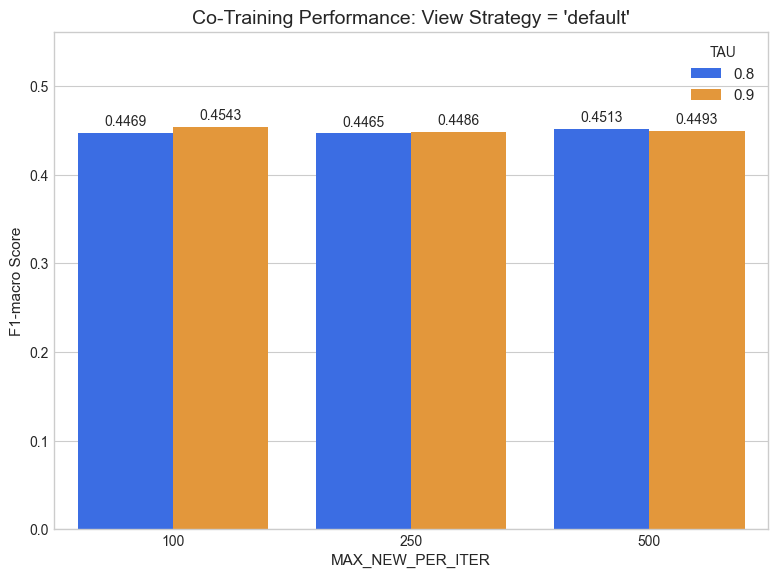

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------- Cấu hình biểu đồ --------
IMAGES_DIR = PROJECT_ROOT / "images"
IMAGES_DIR.mkdir(exist_ok=True)
FONT_CONFIG = {'fontname': 'Arial', 'fontsize': 11}
PALETTE = {
    "default": "#1F62FF",              # Xanh nước biển
    "manual_weather_split": "#FF9A1F", # Cam
    "pca_based_split": "#1FFF2A"       # Xanh lá cây
}

# -------- Biểu đồ so sánh F1-macro (Tách riêng từng View Strategy) --------
if 'df_results_co' in locals() and not df_results_co.empty:
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Chuyển đổi TAU thành category để seaborn xử lý hue tốt hơn
    if not pd.api.types.is_categorical_dtype(df_results_co['tau']):
        df_results_co['tau'] = df_results_co['tau'].astype('category')

    # Lặp qua từng view_strategy để vẽ biểu đồ riêng
    for i, view_strategy in enumerate(df_results_co['view_strategy'].unique()):
        
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Lọc dữ liệu cho view_strategy hiện tại
        strategy_data = df_results_co[df_results_co['view_strategy'] == view_strategy]
        
        # Vẽ biểu đồ cột
        sns.barplot(
            data=strategy_data,
            x="max_new_per_iter",
            y="f1_macro",
            hue="tau",
            palette=['#1F62FF', '#FF9A1F'], # Màu cho TAU
            ax=ax,
            errorbar=None # Tắt đường kẻ lỗi (error bar)
        )
        
        # Thêm text giá trị trên cột
        for container in ax.containers:
            ax.bar_label(container, fmt='%.4f', fontsize=10, padding=3)
            
        # Định dạng
        ax.set_xlabel("MAX_NEW_PER_ITER", **FONT_CONFIG)
        ax.set_ylabel("F1-macro Score", **FONT_CONFIG)
        ax.set_ylim(0, df_results_co['f1_macro'].max() * 1.15)
        
        title_font_config = FONT_CONFIG.copy()
        title_font_config['fontsize'] = 14
        ax.set_title(f"Co-Training Performance: View Strategy = '{view_strategy}'", **title_font_config)
        
        ax.legend(title='TAU', prop={'family': 'Arial', 'size': 11})
        
        plt.tight_layout(pad=1.5)
        
        # Lưu biểu đồ
        save_path = IMAGES_DIR / f"11_{i+1:02d}_co_training_{view_strategy}.png"
        plt.savefig(save_path, dpi=300)
        print(f"Biểu đồ đã được lưu tại: {save_path}")
        
        plt.show()

Biểu đồ đường đã được lưu tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\11_02_co_training_line_chart.png


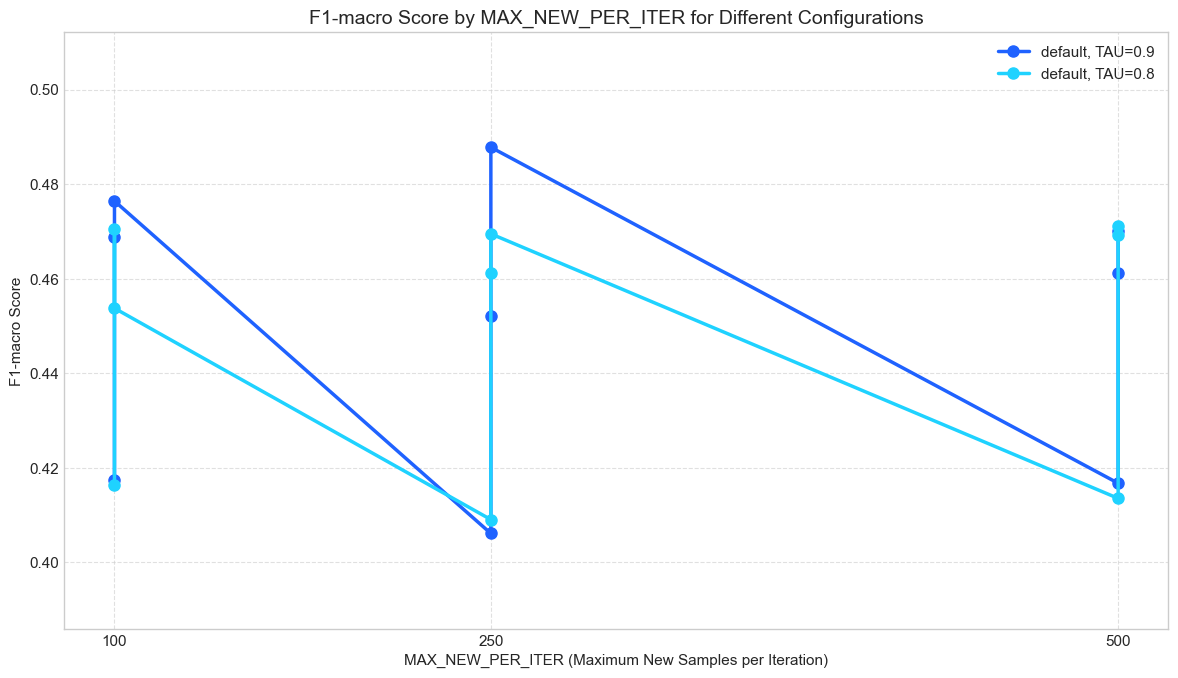

In [8]:
# -------- Biểu đồ đường: F1-macro theo MAX_NEW_PER_ITER --------
if 'df_results_co' in locals() and not df_results_co.empty:
    fig, ax = plt.subplots(figsize=(12, 7))

    # Chuẩn bị dữ liệu
    max_new_values = sorted(df_results_co["max_new_per_iter"].unique())
    
    # Định nghĩa bảng màu cho các tổ hợp view_strategy + TAU
    line_colors = {
        ('default', 0.9): '#1F62FF',                 # Xanh nước biển đậm
        ('default', 0.8): '#1FD2FF',                 # Xanh nước biển nhạt
        ('manual_weather_split', 0.9): '#FF9A1F',    # Cam
        ('manual_weather_split', 0.8): '#FFDA1F',    # Vàng
        ('pca_based_split', 0.9): '#1FFF2A',         # Xanh lá cây
        ('pca_based_split', 0.8): '#1FD2FF',         # Gradient xanh lá nhạt (tạm dùng xanh nước biển nhạt)
    }
    
    # Vẽ đường cho mỗi tổ hợp view_strategy và TAU
    for (view_strategy, tau), color in line_colors.items():
        # Lọc dữ liệu
        mask = (df_results_co["view_strategy"] == view_strategy) & (df_results_co["tau"] == tau)
        line_data = df_results_co[mask].sort_values("max_new_per_iter")
        
        if not line_data.empty:
            # Vẽ đường với marker
            ax.plot(line_data["max_new_per_iter"], line_data["f1_macro"],
                   marker='o',
                   linewidth=2.5,
                   markersize=8,
                   color=color,
                   label=f'{view_strategy}, TAU={tau}')
     
    
    # Thêm nhãn và tiêu đề
    ax.set_xlabel('MAX_NEW_PER_ITER (Maximum New Samples per Iteration)', **FONT_CONFIG)
    ax.set_ylabel('F1-macro Score', **FONT_CONFIG)
    
    title_font_config = FONT_CONFIG.copy()
    title_font_config['fontsize'] = 14
    ax.set_title('F1-macro Score by MAX_NEW_PER_ITER for Different Configurations', **title_font_config)
    
    # Cấu hình trục và lưới
    ax.set_xticks(max_new_values)
    ax.tick_params(axis='both', labelsize=11)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(prop={'family': 'Arial', 'size': 11}, loc='best')
    
    # Đặt giới hạn trục y
    y_min = df_results_co['f1_macro'].min() * 0.95
    y_max = df_results_co['f1_macro'].max() * 1.05
    ax.set_ylim(y_min, y_max)
    
    plt.tight_layout(pad=1.5)
    
    # Lưu biểu đồ
    save_path = IMAGES_DIR / "11_02_co_training_line_chart.png"
    plt.savefig(save_path, dpi=300)
    print(f"Biểu đồ đường đã được lưu tại: {save_path}")

    plt.show()